In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
#%load_ext autoreload
#%autoreload 2

import os
import pandas as pd
from pandas import factorize
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy import stats

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

In [2]:
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

def rf_sklearn(X_train,y_train,X_test,y_test,feature_names,tmp_col_y,figPath,is_plot_imp = False):
    rf = RandomForestRegressor(random_state= 10)
    rf.fit(X_train,y_train)
    y_train_pred = rf.predict(X_train)
    y_pred = rf.predict(X_test)
    """
    test_var = metrics.mean_squared_error(y_test, y_pred)
    train_var = metrics.mean_squared_error(y_train, y_train_pred)
    test_std = np.sqrt(test_var)
    train_std = np.sqrt(train_var)
    """

    test_std = np.abs(y_test - y_pred)
    train_std = np.abs(y_train - y_train_pred)
    
    importances=rf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

    forest_importances = pd.Series(importances, index=feature_names)

    if is_plot_imp:
        fig, ax = plt.subplots()
        forest_importances.plot.bar(yerr=std, ax=ax)
        ax.set_title(tmp_col_y + " Feature importances")
        ax.set_ylabel("Mean decrease in impurity")
        fig.tight_layout()
        figName = tmp_col_y + 'featureImp.jpg'
        plt.savefig(os.path.join(figPath,figName))
    
    return y_train_pred, train_std, y_pred, test_std, forest_importances

In [3]:
# We will use the simplest form of GP model, exact inference
import gpytorch
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
def simpleGP_gpytorch(t_train_x,t_test_x,t_train_y,training_iter = 50):
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(t_train_x, t_train_y, likelihood)
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()
    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(t_train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, t_train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item()
        ))
        optimizer.step()
    
    # Set into eval mode
    model.eval()
    model.likelihood.eval()


    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_pred = model.likelihood(model(t_test_x))   
        test_mean = test_pred.mean
        test_lower, test_upper = test_pred.confidence_region()
        train_pred = model.likelihood(model(t_train_x))
        train_mean = train_pred.mean
        train_lower, train_upper = train_pred.confidence_region()
    return test_mean, test_lower, test_upper, train_mean, train_lower, train_upper

In [4]:
#M3GPR-O
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood,num_tasks, rank = 0):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=num_tasks
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=num_tasks, rank=rank
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [5]:
#M3GPR-R
class MultiOutputMultiTaskGP(gpytorch.models.ExactGP):

    def __init__(
        self,
        train_X,
        train_Y,
        likelihood,
        data_kernel = 'Matern',
        task_rank = None,
        output_rank = None
    ) -> None:

        num_outputs = train_Y.shape[-1]
        num_tasks = len(torch.unique(train_X[..., -1]))
        #batch_shape, ard_num_dims = train_X.shape[:-2], train_X.shape[-1]
                       
        #self._validate_tensor_args(X=train_X, Y=train_Y)

        super(MultiOutputMultiTaskGP, self).__init__(train_X, train_Y,likelihood)
        self.task_rank = task_rank if task_rank is not None else num_tasks
        self.output_rank = output_rank if output_rank is not None else num_outputs

        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=num_outputs
        )
        
        if data_kernel == 'Matern':
            self.data_kernel = gpytorch.kernels.MaternKernel()
        else:
            self.data_kernel = gpytorch.kernels.RBFKernel()
        self.task_kernel = gpytorch.kernels.IndexKernel(num_tasks=num_tasks, rank = self.task_rank) #default rank is 1
        self.output_kernel = gpytorch.kernels.IndexKernel(num_tasks=num_outputs, rank = self.output_rank) #default rank is 1
        
        self.to(train_X)
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        task_term = self.task_kernel(x[..., -1].long())
        data_and_task_x = self.data_kernel(x[..., :-1]).mul(task_term)
        output_x = self.output_kernel.covar_matrix
        covar_x = gpytorch.lazy.KroneckerProductLazyTensor(data_and_task_x, output_x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

## Opensource Biopharm Data

In [75]:
os.chdir('/Users/chenya68/Documents/GitHub/BFO')
#df = pd.read_csv('data/biopharm-correlated-data.csv',index_col = 0)
df = pd.read_csv('data/biopharm-correlated-data-corr+0.5-scaled.csv',index_col = 0)
#df = pd.read_csv('data/biopharm-correlated-data-corr+0.9-scaled.csv',index_col = 0)
print(len(df))
#df['NP'] = df['NP']-df['NP'].min()+1
#df['NP'] = np.log1p(df['NP'])
#df['NP'].isnull().sum()

66


In [76]:
df1 = df[df['task_ind']==0]
df2 = df[df['task_ind']==1]

Round ['Intial' 'Round 1' 'Round 2' 'Round 3']
pH [5.  5.5 6.  6.5]
NaCl_mM_ [15.         18.33       11.67        8.33       41.67        1.67
 25.         45.         48.33       38.33       31.67       28.33
 35.          5.          6.          3.1         4.4         2.6
 10.         11.3        10.8        11.5         0.5         6.2
  3.8         0.9        16.5        32.5        20.         26.
  8.33333333]
Trehalose_w_v_ [7.  1.  5.  4.  2.  0.  9.  3.  7.1 6.1 1.1 6.  7.2 8.7 4.6 8.  9.5 9.4
 9.7 8.8 9.8]
Mannitol_w_v_ [0.  3.  5.  4.  2.  4.8 4.4 3.8 4.6 4.7 4.2 3.6 4.5 3.2]
Tween_20_v_v_ [0.01  0.    0.001 0.1   0.09  0.07  0.06  0.08  0.05 ]
Tm [59.34782168 59.45301223 61.82036553 62.13379327 61.22497573 61.73605821
 62.29108992 60.96488982 61.65449862 60.50229093 62.22476516 61.83766571
 62.43323173 62.17509205 62.33521596 62.37723904 61.65221587 62.20589001
 62.54626224 62.6484525  61.8502798  62.78463136 63.08590532 63.1275002
 62.9535771  62.8179463  63.04782664 63.

/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/seaborn/_oldcor

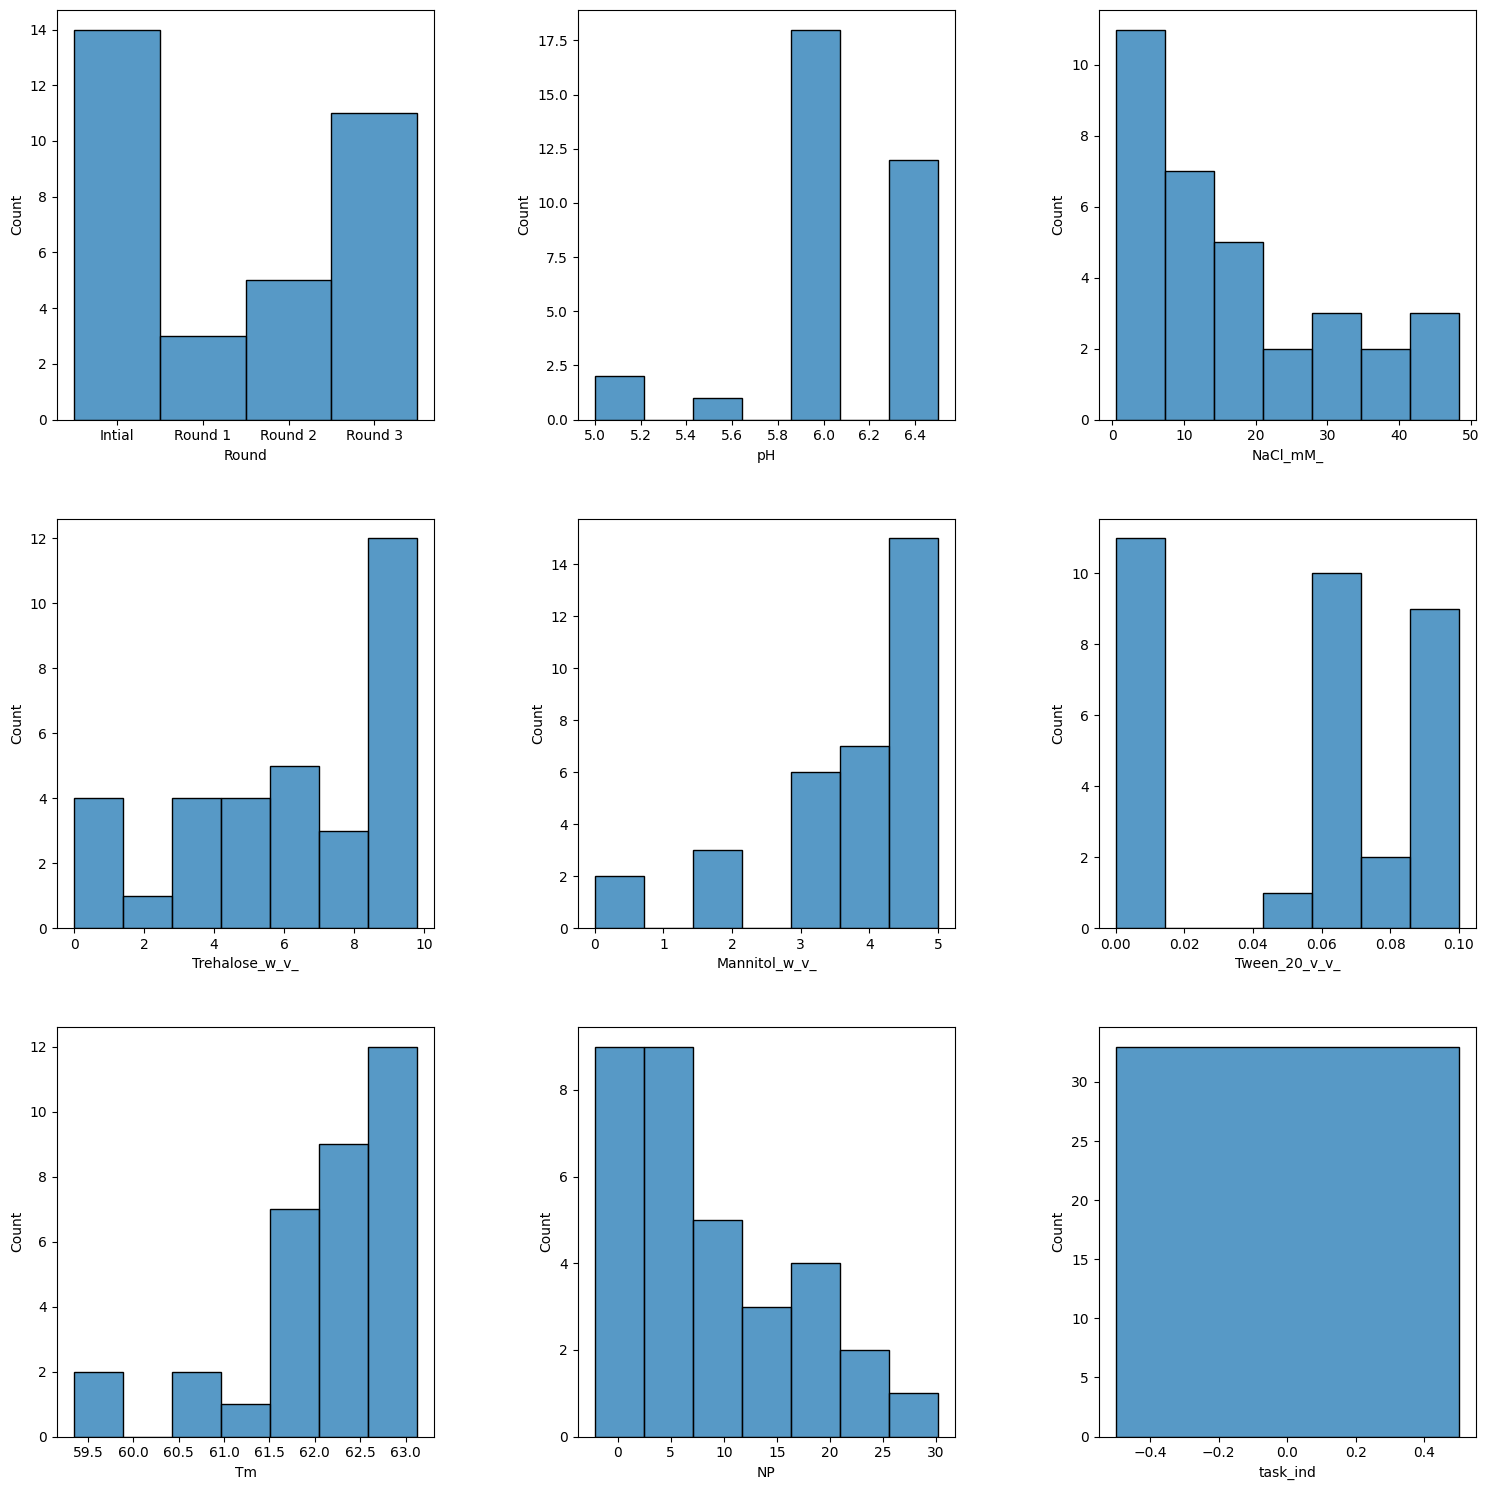

In [159]:
import seaborn as sns
fig, axes = plt.subplots(3,3, figsize=(15, 15))
#fig, axes = plt.subplots(10,3, figsize=(20, 20))
ax = axes.flatten()

for i, col in enumerate(df1.columns):
    print(col,df1[col].unique())
    if col != 'pH':
        sns.histplot(df1[col], ax=ax[i]) 
        #n_bin = 4
        #sns.histplot(df_x[col], ax=ax[i],bins = n_bin) # histogram call
    else:
        sns.histplot(df1[col], ax=ax[i]) 
    #ax[i].set_title(col)
    # remove scientific notation for both axes
    if col != 'Round':
        ax[i].ticklabel_format(style='plain', axis='both')

fig.tight_layout(w_pad=6, h_pad=4) # change padding
#figName = 'featureDist.jpg'
#plt.savefig(os.path.join(figPath,figName))
plt.show()

Round ['Intial' 'Round 1' 'Round 2' 'Round 3']
pH [5.  5.5 6.  6.5]
NaCl_mM_ [15.         18.33       11.67        8.33       41.67        1.67
 25.         45.         48.33       38.33       31.67       28.33
 35.          5.          6.          3.1         4.4         2.6
 10.         11.3        10.8        11.5         0.5         6.2
  3.8         0.9        16.5        32.5        20.         26.
  8.33333333]
Trehalose_w_v_ [7.  1.  5.  4.  2.  0.  9.  3.  7.1 6.1 1.1 6.  7.2 8.7 4.6 8.  9.5 9.4
 9.7 8.8 9.8]
Mannitol_w_v_ [0.  3.  5.  4.  2.  4.8 4.4 3.8 4.6 4.7 4.2 3.6 4.5 3.2]
Tween_20_v_v_ [0.01  0.    0.001 0.1   0.09  0.07  0.06  0.08  0.05 ]
Tm [48.402073   47.21448491 49.15590474 49.09680403 49.47216478 48.07989003
 50.82520058 48.33898985 49.50504634 48.26000807 50.61135832 48.29846656
 49.7632167  49.52165    50.51298266 49.2762489  49.22370742 49.26544666
 50.06101806 50.45022711 48.85426753 50.87874502 50.9814869  50.7877843
 50.87520644 49.86549977 50.36836983 49.

/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/seaborn/_oldcor

NP [15.48801068  9.17825225 15.38937766 -1.39353062 15.60624241 12.53676551
 21.22994454  0.53814199 16.64100905  3.9467887  26.74759625  5.87924978
 11.88942147 13.40664249 13.15218238  0.18594712  5.35935884  1.24936193
  2.66500739  3.41863789 -0.34490879  7.04709008  8.51886889  5.19619771
  2.82715234 -2.43094083  0.71390602 -5.59724237 -2.41028061  4.36936606
 -4.02027266  0.40229512  0.03245481]
task_ind [1]


/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


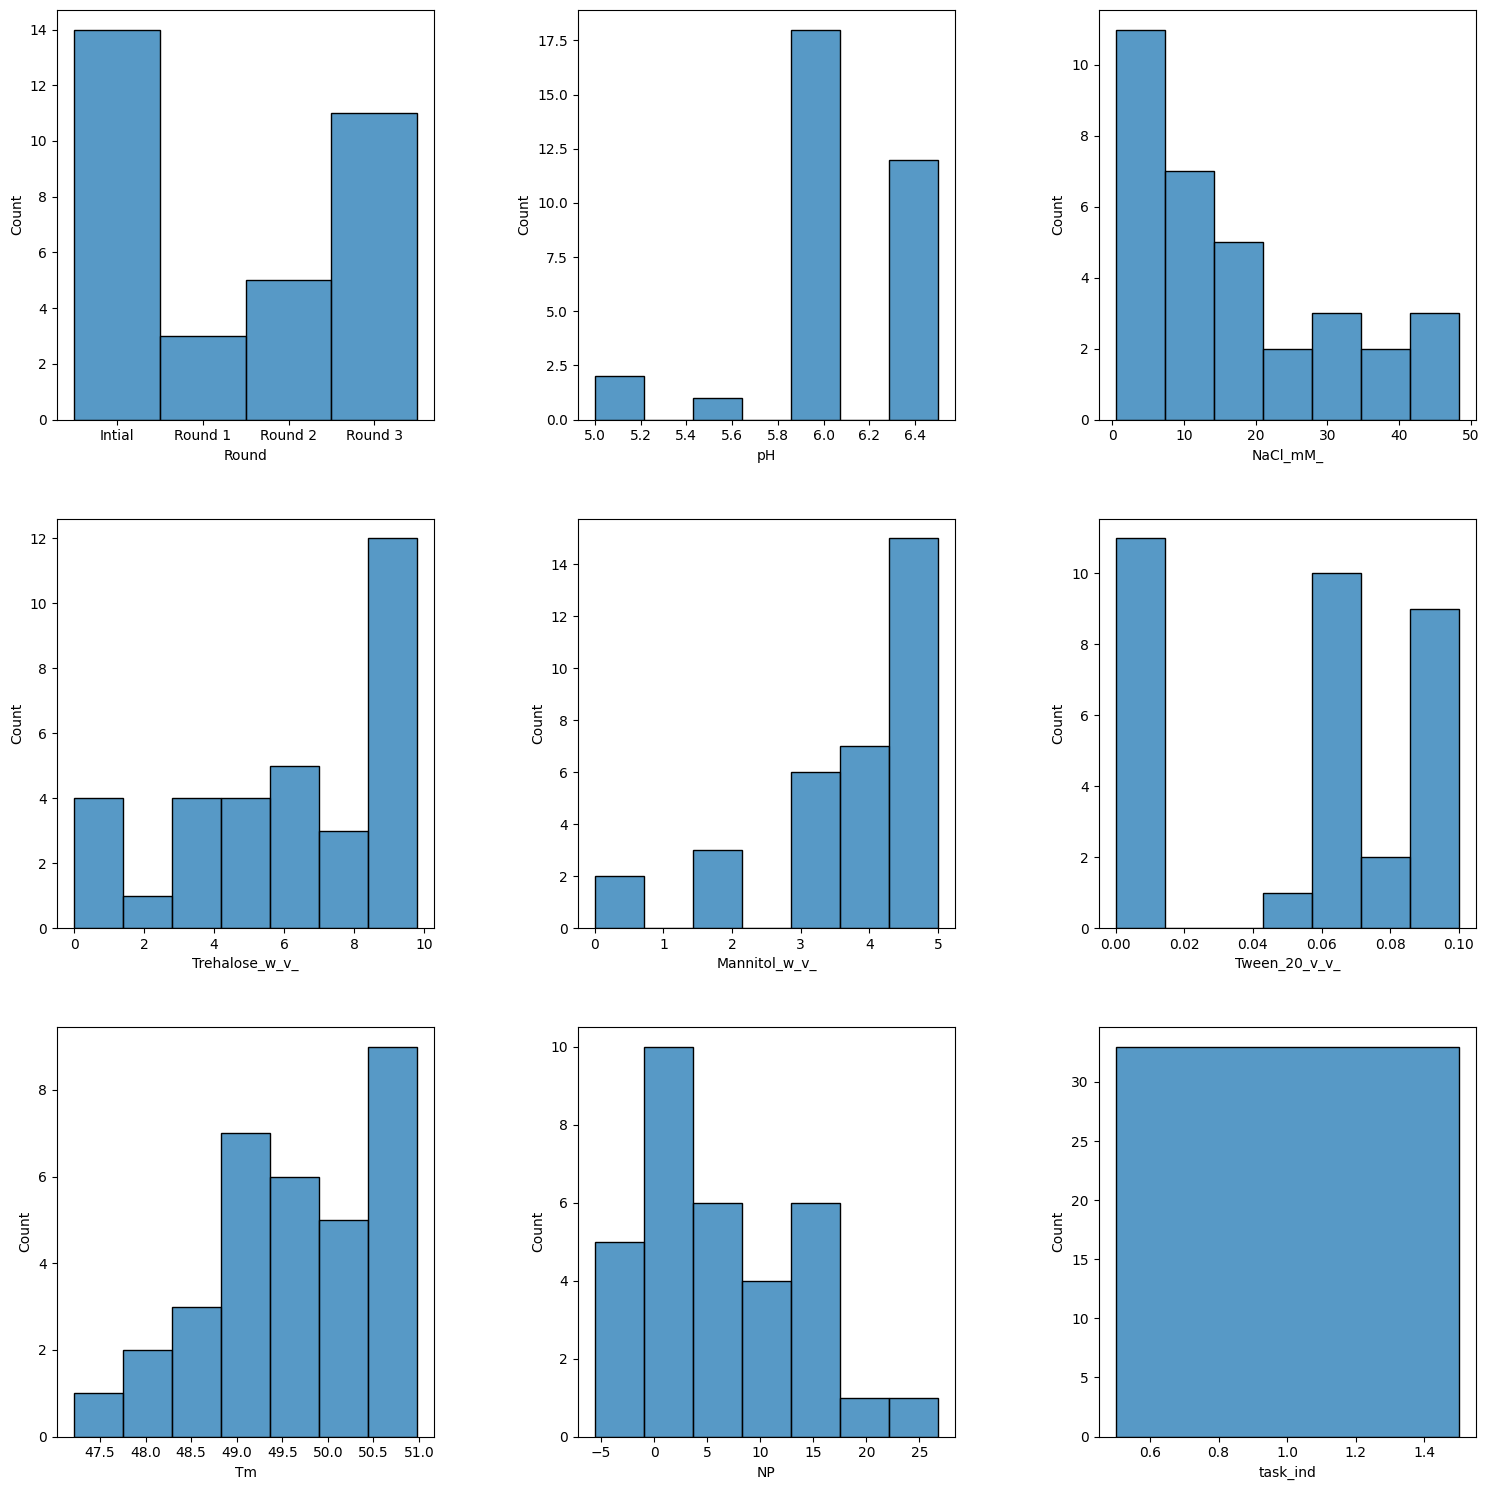

In [160]:
fig, axes = plt.subplots(3,3, figsize=(15, 15))
#fig, axes = plt.subplots(10,3, figsize=(20, 20))
ax = axes.flatten()

for i, col in enumerate(df2.columns):
    print(col,df2[col].unique())
    if col != 'pH':
        sns.histplot(df2[col], ax=ax[i]) 
        #n_bin = 4
        #sns.histplot(df_x[col], ax=ax[i],bins = n_bin) # histogram call
    else:
        sns.histplot(df2[col], ax=ax[i]) 
    #ax[i].set_title(col)
    # remove scientific notation for both axes
    if col != 'Round':
        ax[i].ticklabel_format(style='plain', axis='both')

fig.tight_layout(w_pad=6, h_pad=4) # change padding
#figName = 'featureDist.jpg'
#plt.savefig(os.path.join(figPath,figName))
plt.show()

In [77]:
ls_model = ['rf','simpleGP-sklearn','simpleGP-gpytorch','multi-task-single-output','multi-task-multi-output','multi-task-multi-input-multi-output']
ls_x_scale = ['no-x-scale','x-minmax','x-stand','x-robust']
ls_y_scale = ['no-y-scale','y-minmax','y-stand','y-robust', 'y-norm-sklearn']
ls_n_cate = ['no-cate','one-cate']
ls_cate_transform = ['label','ohe','LVGP','partial-LMGP','partial-LMGP-per-task','full-LMGP-per-task']
ls_output_rank_option = [0,1,2]
ls_task_rank_option = [0,1,2,3,4,5,6,7]
ls_lik_rank_option = [0,1,2]
ls_stratify_task = ['not-stratify','stratify-x']

In [94]:
#model_option = 'rf'
#model_option = 'simpleGP'
model_option = 'multi-task-single-output'
#model_option = 'multi-task-multi-output'
x_scale_option = 'x-minmax'
y_scale_option = 'y-minmax' #GaussianProcessRegressor has a normalize_y argument

#cate_option = ['pH','Tween_20_v_v_']
#cate_option = ['pH', 'Mannitol_w_v_', 'Tween_20_v_v_']
cate_option = ['pH', 'Trehalose_w_v_', 'Mannitol_w_v_', 'Tween_20_v_v_']
#cate_option = cols_feature.difference(['NaCl_mM_','Trehalose_w_v_'])
#cate_option = cols_feature
#cate_option = cols_feature.difference(['NaCl_mM_'])
#cate_option = []
if len(cate_option) > 0:
        #cate_transform_option = 'full-LMGP-per-task'
        #cate_transform_option = 'partial-LMGP-per-task'
        cate_transform_option = 'label'
else:
        cate_transform_option = ''
if model_option != 'simpleGP':
        output_rank_option = 2
        task_rank_option = 2
        lik_rank_option = 1
else:
        output_rank_option = ''
        lik_rank_option = ''
        task_rank_option = ''

#stratify_option = 'stratify-x'

model_label = model_option
x_scale_label = x_scale_option
y_scale_label = y_scale_option
cate_label = 'n_cate_var_'+str(len(cate_option))
cate_transform_label = 'cate_transform_'+cate_transform_option
if model_option != 'simpleGP':
        output_rank_label = 'output_rank_'+str(output_rank_option)
        task_rank_label = 'task_rank_'+str(task_rank_option)
        lik_rank_label = 'lik_rank_'+str(lik_rank_option)
else:
        output_rank_label = str(output_rank_option)
        task_rank_label = str(task_rank_option)
        lik_rank_label = str(lik_rank_option)

"""

remove_pred_outlier_label = 'remove_pred_outlier_'+str(remove_pred_outlier_option)



split_label = split_option
stratify_label = stratify_option
"""

#folder_name = '-'.join([model_label,task_rank_label,output_rank_label,lik_rank_label,x_scale_label,y_scale_label,cate_transform_label,
#                        remove_pred_outlier_label,split_label,stratify_label])

folder_name = '-'.join([model_label,output_rank_label,task_rank_label,lik_rank_label,
                        x_scale_label,y_scale_label,cate_label,cate_transform_label])

figPath = 'output/opensource-correlated-2outputs-corr+0.9-scaled-0613/'+folder_name

if not os.path.exists(figPath):
        print(f'Creating folder {figPath}')
        os.makedirs(figPath,exist_ok = True)

In [95]:
cols_feature = ['pH', 'NaCl_mM_', 'Trehalose_w_v_', 'Mannitol_w_v_',
       'Tween_20_v_v_']

cols_target = ['Tm', 'NP']


In [96]:
df_x = df[cols_feature + ['task_ind']]
df_y = df[cols_target]



x_name = 'NaCl_mM_'
#best_n_clusters = 15
best_n_clusters = 5
km = KMeans(n_clusters=best_n_clusters, random_state=10)
kmeans = km.fit(df_x[[x_name]])
df_x[x_name+"_label"] = kmeans.labels_


x_name = 'Trehalose_w_v_'
#best_n_clusters = 7
best_n_clusters = 4
km = KMeans(n_clusters=best_n_clusters, random_state=10)
kmeans = km.fit(df_x[[x_name]])
df_x[x_name+"_label"] = kmeans.labels_


x_name = 'Mannitol_w_v_'
#best_n_clusters = 10
best_n_clusters = 3
km = KMeans(n_clusters=best_n_clusters, random_state=10)
kmeans = km.fit(df_x[[x_name]])
df_x[x_name+"_label"] = kmeans.labels_


x_name = 'Tween_20_v_v_'
#best_n_clusters = 9
best_n_clusters = 3
km = KMeans(n_clusters=best_n_clusters, random_state=10)
kmeans = km.fit(df_x[[x_name]])
df_x[x_name+"_label"] = kmeans.labels_


#convert pH column to labels
x_name = 'pH'
labels, categories = factorize(df_x[x_name])
df_x[x_name+"_label"] = labels
#df_x

/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_58785/2612922104.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x[x_name+"_label"] = kmeans.labels_
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_58785/2612922104.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x[x_name+"_label"] = kmeans.labels_


In [97]:
if model_option == 'multi-task-single-output':
    df_x_new = df_x[df_x['task_ind']==0]
    df_y_1 = df_y.iloc[:len(df1)]
    df_y_2 = df_y.iloc[len(df1):]
    df_y_1.reset_index(drop = True, inplace = True)
    df_y_2.reset_index(drop = True, inplace = True)
    df_y_new = pd.concat((df_y_1,df_y_2),axis = 1)
    df_y_new.columns = ['Tm_1','NP_1','Tm_2','NP_2']

In [487]:
#!pip install seaborn --upgrade

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2


/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_43414/3319427110.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  corr['Task2_Output2'][1] = 0.5
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_43414/3319427110.py:9: 

               Task1_Output1  Task1_Output2  Task2_Output1  Task2_Output2
Task1_Output1       1.000000      -0.409118       0.527813      -0.196244
Task1_Output2      -0.409118       1.000000      -0.328386       0.500000
Task2_Output1       0.527813      -0.328386       1.000000       0.616769
Task2_Output2      -0.196244       0.500000       0.616769       1.000000


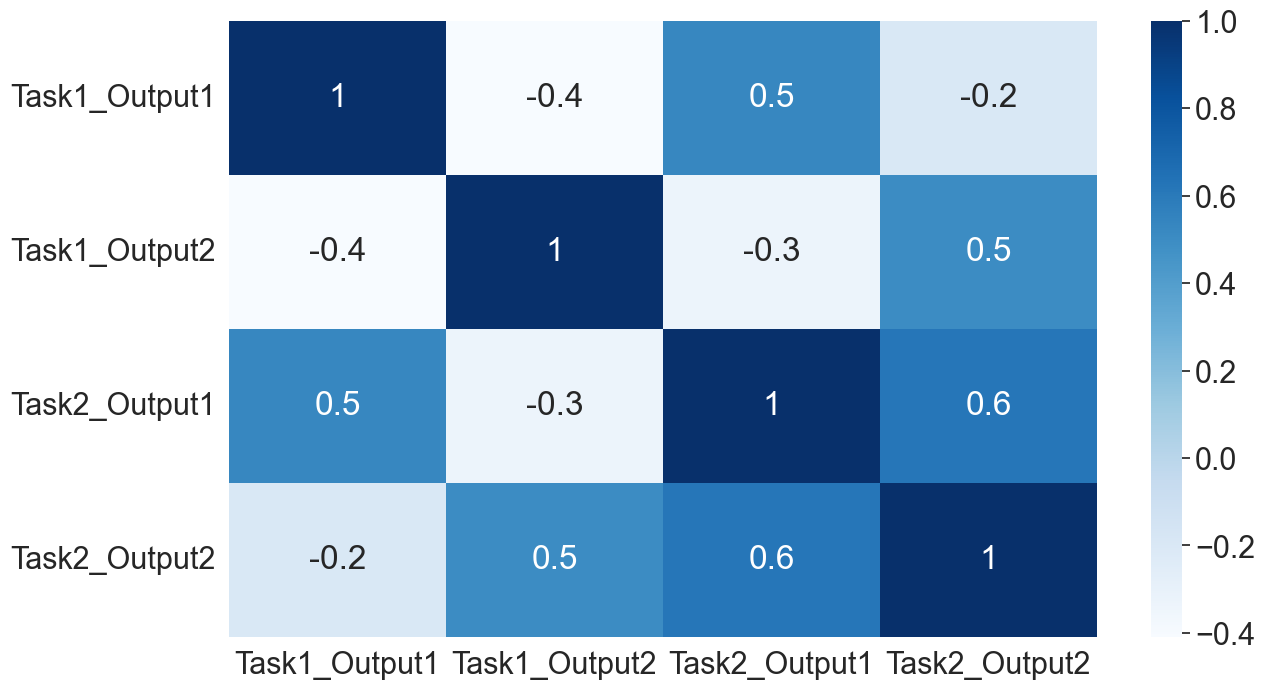

In [47]:
#task correlation 0.5
import seaborn as sns
plt.figure(figsize=(14,8))
sns.set_theme(style="white")
sns.set(font_scale=2)
df_y_new2 = df_y_new.copy()
df_y_new2.columns = ['Task1_Output1','Task1_Output2','Task2_Output1','Task2_Output2']
corr = df_y_new2.corr()
corr['Task2_Output2'][1] = 0.5
corr['Task1_Output2'][3] = 0.5
print(corr)
#corr = df_y_new2[['Task1_Output1','Task2_Output1']].corr()
heatmap = sns.heatmap(corr, annot=True, cmap="Blues", fmt='.1g')
#,annot_kws={"fontsize":20}

               Task1_Output1  Task1_Output2  Task2_Output1  Task2_Output2
Task1_Output1       1.000000      -0.409118       0.906527      -0.379267
Task1_Output2      -0.409118       1.000000      -0.426765       0.893893
Task2_Output1       0.906527      -0.426765       1.000000      -0.206267
Task2_Output2      -0.379267       0.893893      -0.206267       1.000000


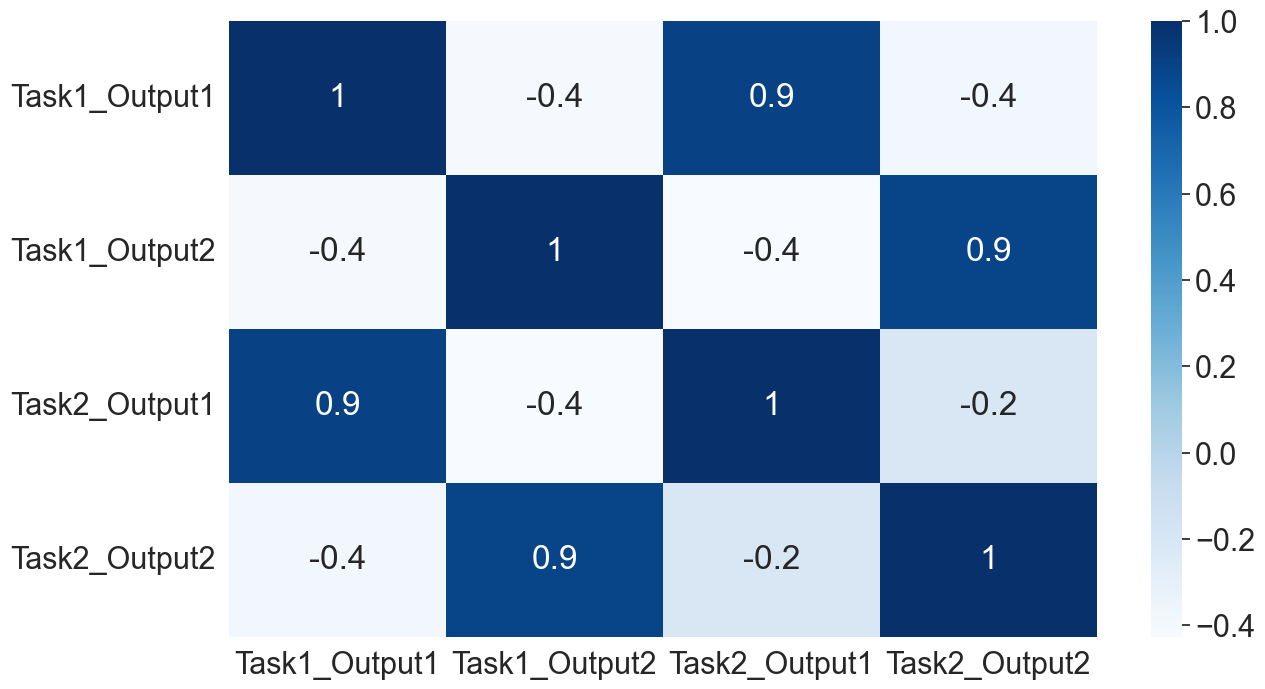

In [25]:
#task correlation 0.9
plt.figure(figsize=(14,8))
sns.set_theme(style="white")
sns.set(font_scale=2)
df_y_new2 = df_y_new.copy()
df_y_new2.columns = ['Task1_Output1','Task1_Output2','Task2_Output1','Task2_Output2']
corr = df_y_new2.corr()
print(corr)
#corr = df_y_new2[['Task1_Output1','Task2_Output1']].corr()
heatmap = sns.heatmap(corr, annot=True, cmap="Blues", fmt='.1g')

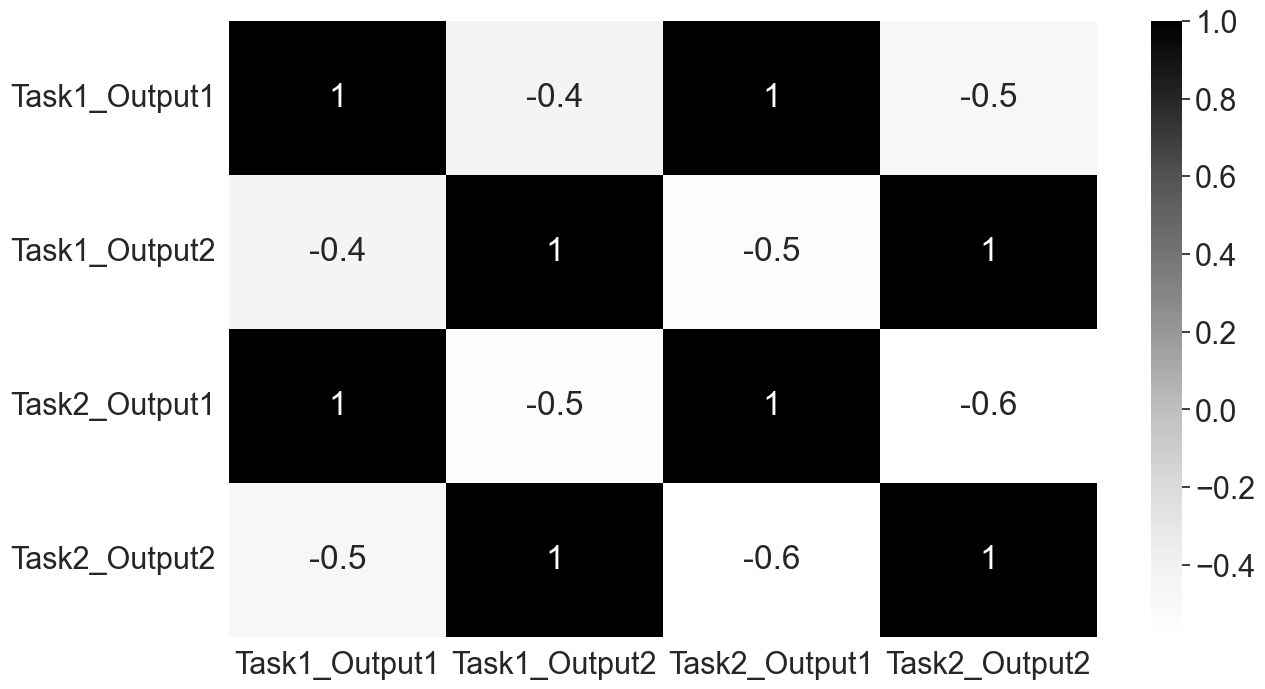

In [34]:
opt_corr_09 = np.array([[ 1. ,    -0.4346,  0.9894, -0.4809],
 [-0.4346,  1.,     -0.542,   0.9978],
 [ 0.9894, -0.542,   1.,     -0.5848],
 [-0.4809,  0.997, -0.5848,  1.    ]])
plt.figure(figsize=(14,8))
sns.set_theme(style="white")
sns.set(font_scale=2)
axis_labels = ['Task1_Output1','Task1_Output2','Task2_Output1','Task2_Output2']
heatmap = sns.heatmap(opt_corr_09, annot=True, cmap="Grays",fmt='.1g',xticklabels=axis_labels, yticklabels=axis_labels)

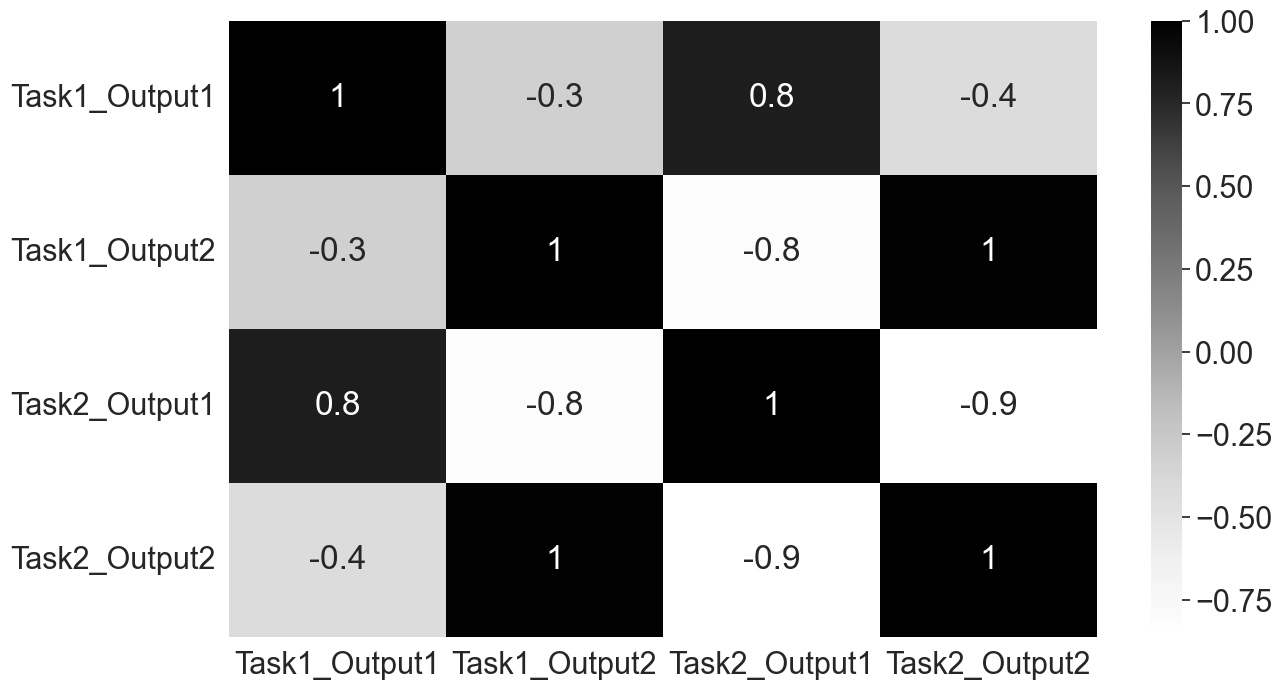

In [35]:
opt_corr_05 = np.array([[ 1.,     -0.3229,  0.8133, -0.4226],
 [-0.3229,  1.,     -0.8074,  0.9835],
 [ 0.8133, -0.8074,  1.,     -0.8627],
 [-0.4226,  0.9835, -0.8627,  1.    ]])
plt.figure(figsize=(14,8))
sns.set_theme(style="white")
sns.set(font_scale=2)
axis_labels = ['Task1_Output1','Task1_Output2','Task2_Output1','Task2_Output2']
heatmap = sns.heatmap(opt_corr_05, annot=True, cmap="Grays",fmt='.1g',xticklabels=axis_labels, yticklabels=axis_labels)

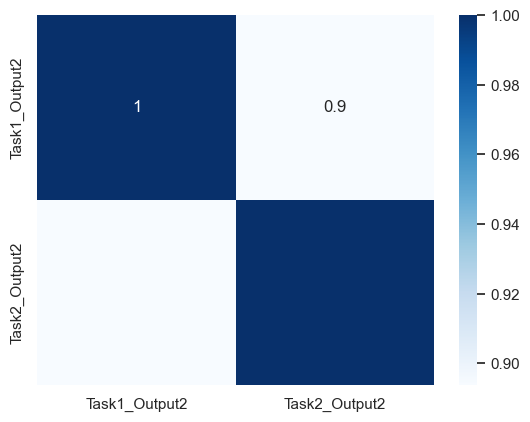

In [335]:
corr = df_y_new2[['Task1_Output2','Task2_Output2']].corr()
heatmap = sns.heatmap(corr, annot=True, cmap="Blues", fmt='.1g')

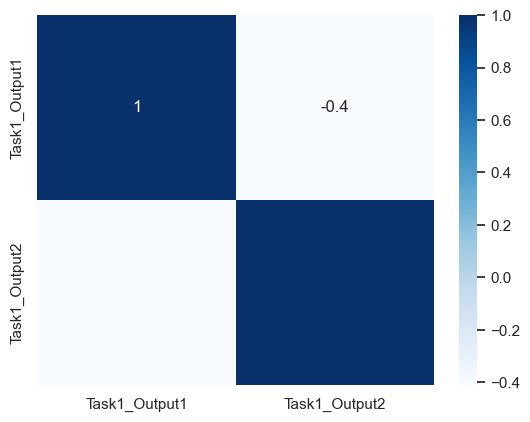

In [336]:
corr = df_y_new2[['Task1_Output1','Task1_Output2']].corr()
heatmap = sns.heatmap(corr, annot=True, cmap="Blues", fmt='.1g')

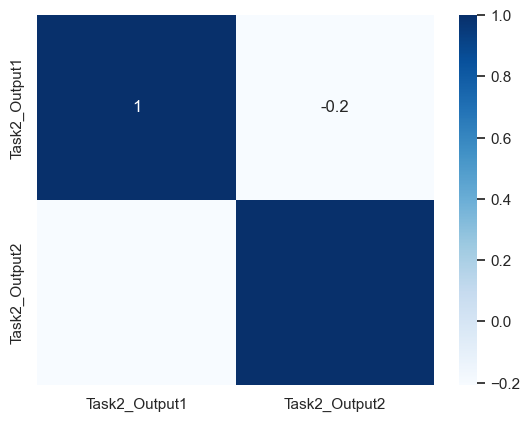

In [337]:
corr = df_y_new2[['Task2_Output1','Task2_Output2']].corr()
heatmap = sns.heatmap(corr, annot=True, cmap="Blues", fmt='.1g')

In [98]:
s = set(cate_option)
cols_numeric = [x for x in cols_feature if x not in s]
cols_numeric

if len(cate_option) == 0:
    cols_cate = []
    if model_option == 'multi-task-single-output':
        cols_feature_new = cols_feature
    else:
        cols_feature_new = cols_feature + ['task_ind']
else:
    cols_cate = [x + '_label' for x in cate_option]
    if model_option == 'multi-task-single-output':
        cols_feature_new = cols_cate + list(cols_numeric)
    else:
        cols_feature_new = cols_cate + list(cols_numeric) + ['task_ind']
    #cols_cate = ['pH_label','Trehalose_w_v_label', 
    #                  'Mannitol_w_v_label', 'Tween_20_v_v_label']

    #cols_feature_new = ['pH_label', 'NaCl_mM_', 'Trehalose_w_v_label', 
    #                  'Mannitol_w_v_label', 'Tween_20_v_v_label']

cols_target = list(df_y.columns)
if model_option == 'multi-task-single-output':
    df_x_select = df_x_new[cols_feature_new]
    df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df_x_select, df_y_new, 
                                                                test_size=0.2, 
                                                                random_state=0)
else:
    df_x_select = df_x[cols_feature_new]
    df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df_x_select, df_y, 
                                                                test_size=0.2, 
                                                                random_state=0,
                                                                stratify=df_x_select['task_ind'])
display(df_X_test)

,pH_label,Trehalose_w_v__label,Mannitol_w_v__label,Tween_20_v_v__label,NaCl_mM_
11,3,3,2,1,28.33
20,2,3,0,0,11.30
24,3,2,0,2,6.20
17,2,0,0,0,4.40
2,1,3,0,1,11.67
25,2,2,0,0,3.80
26,3,2,0,2,0.90


In [99]:
from sklearn.compose import ColumnTransformer
#cols_exception = []
if model_option == 'multi-task-single-output':
    cols_exception = cols_cate
else:
    cols_exception = cols_cate + ['task_ind']
if x_scale_label == 'x-minmax':
    xct = ColumnTransformer([('x_mm_scaler',MinMaxScaler(),
                          df_X_train.columns.difference(cols_exception))], 
                         remainder = 'passthrough')

    scaled_X_train=xct.fit_transform(df_X_train) 
    scaled_X_test=xct.transform(df_X_test)

    t_train_x = torch.Tensor(scaled_X_train)
    t_test_x = torch.Tensor(scaled_X_test)
elif x_scale_label == 'no-x-scale':
    scaled_X_train=df_X_train.to_numpy()
    scaled_X_test=df_X_test.to_numpy()

    t_train_x = torch.Tensor(df_X_train.to_numpy())
    t_test_x = torch.Tensor(df_X_test.to_numpy())

In [ ]:
#simpleGP and rf
#if x_scale_option>0:

y_plot_scale_label='no-y-scale'

uncertainty_figure_option = 'errorbar' #shade or errorbar
is_set_axis_limit = False
cols_target_new = ['Tm_1', 'NP_1',
       'Tm_2', 'NP_2']

plot_axis_lb = df_y[cols_target].min(axis = 0) - 0.4*df_y[cols_target].std(axis = 0)
plot_axis_ub = df_y[cols_target].max(axis = 0) + 0.4* df_y[cols_target].std(axis = 0)

num_outputs = len(cols_target)
num_tasks = 2

num_total_output = num_outputs*num_tasks
arr_train_metrics = np.zeros((11,num_total_output))
arr_test_metrics = np.zeros((11,num_total_output))

# Initialize plots
f, y_axes = plt.subplots(num_tasks, num_outputs, figsize=(num_outputs*8, num_tasks*7))
y_axes = y_axes.ravel()
for task_ind in range(num_tasks):
  y_train_task = df_y_train.iloc[scaled_X_train[:,-1]==task_ind,:].to_numpy()
  y_test_task = df_y_test.iloc[scaled_X_test[:,-1]==task_ind,:].to_numpy()

  t_train_x_task = t_train_x[t_train_x[:,-1]==task_ind]
  t_test_x_task = t_test_x[t_test_x[:,-1]==task_ind]

  arr_train_x = t_train_x_task.detach().numpy()
  arr_test_x = t_test_x_task.detach().numpy()
  for j,_ in enumerate(cols_target):
    a = j + len(cols_target)*task_ind
    tmp_col_y = cols_target_new[a]

    if model_option == 'rf':
      X_train = scaled_X_train[scaled_X_train[:,-1]==task_ind]
      X_test = scaled_X_test[scaled_X_test[:,-1]==task_ind]
      y_train = df_y_train.iloc[scaled_X_train[:,-1]==task_ind,j].to_numpy()
      y_true = df_y_test.iloc[scaled_X_test[:,-1]==task_ind,j].to_numpy()
      mean_train_pred, std_train_pred, mean_test_pred, std_test_pred, _, = rf_sklearn(X_train,
                                                                                      y_train,
                                                                                      X_test,
                                                                                      y_true,
                                                                                      cols_feature_new,
                                                                                      tmp_col_y,figPath,
                                                                                      is_plot_imp = False)
      #mean_train = mean_train_pred
      y_pred = mean_test_pred
    elif model_option == 'simpleGP':
      if y_scale_label == 'y-robust' and model_option == 'simpleGP':
        y_scaler = RobustScaler()
        scaled_y_train = y_scaler.fit_transform(y_train_task[:,j].reshape(-1,1))
      elif y_scale_label == 'y-stand' and model_option == 'simpleGP':
        y_scaler = StandardScaler()
        scaled_y_train = y_scaler.fit_transform(y_train_task[:,j].reshape(-1,1))
      elif y_scale_label == 'y-minmax' and model_option == 'simpleGP':
        y_scaler = MinMaxScaler()
        scaled_y_train = y_scaler.fit_transform(y_train_task[:,j].reshape(-1,1))
      else:
        scaled_y_train = y_train_task[:,j]
      
      t_train_y_task = torch.Tensor(scaled_y_train).flatten()
      test_mean,test_lower,test_upper,train_mean,train_lower,train_upper = simpleGP_gpytorch(t_train_x_task,t_test_x_task,t_train_y_task,training_iter = 50)
    
      
      t_test_y_task = torch.Tensor(y_test_task[:,j])
      arr_test_y = t_test_y_task.detach().numpy()

      if y_scale_label=='no-y-scale':
        arr_train_y = t_train_y_task.detach().numpy()
        arr_test_mean = test_mean.detach().numpy()
        arr_test_lower = test_lower.detach().numpy()
        arr_test_upper = test_upper.detach().numpy()

        arr_train_mean = train_mean.detach().numpy()
        arr_train_lower = train_lower.detach().numpy()
        arr_train_upper = train_upper.detach().numpy()
      else:
        arr_train_y = y_scaler.inverse_transform(scaled_y_train)
        arr_train_mean = y_scaler.inverse_transform(train_mean.reshape(-1,1))
        arr_train_lower = y_scaler.inverse_transform(train_lower.reshape(-1,1))
        arr_train_upper = y_scaler.inverse_transform(train_upper.reshape(-1,1))

        arr_test_mean = y_scaler.inverse_transform(test_mean.reshape(-1,1))
        arr_test_lower = y_scaler.inverse_transform(test_lower.reshape(-1,1))
        arr_test_upper = y_scaler.inverse_transform(test_upper.reshape(-1,1))

      y_true = arr_test_y
      y_pred = arr_test_mean
      y_train = arr_train_y
      mean_train_pred = arr_train_mean
      std_train_pred = arr_train_mean - arr_train_lower
      std_test_pred = arr_test_mean - arr_test_lower

    train_comp = np.concatenate((y_train.reshape(-1,1),mean_train_pred.reshape(-1,1)),axis = 1)
    df_train_comp = pd.DataFrame(train_comp,columns = ['true','pred'])
    df_train_comp['upper'] = df_train_comp['pred'] + std_train_pred.squeeze()
    df_train_comp['lower'] = df_train_comp['pred'] - std_train_pred.squeeze()
    df_train_comp['mode'] = 'train'
    
    test_comp = np.concatenate((y_true.reshape(-1,1),y_pred.reshape(-1,1)),axis = 1)
    df_test_comp = pd.DataFrame(test_comp,columns = ['true','pred'])
    df_test_comp['upper'] = df_test_comp['pred'] + std_test_pred.squeeze()
    df_test_comp['lower'] = df_test_comp['pred'] - std_test_pred.squeeze()
    df_test_comp['mode'] = 'test'
    
    df_comp = pd.concat([df_train_comp,df_test_comp])
    df_comp_sorted = df_comp.sort_values(by = ['true'],ascending=True)

    #plot a parity line
    y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['true'], '--',c = 'black')
    
    # Plot training data as blue stars
    y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)

    # Plot training data as red stars
    y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red',markersize=15)
    # Predictive mean as blue line
    y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['pred'],c = 'blue')
    
    if uncertainty_figure_option == 'shade':
    # Shade in confidence
      y_axes[a].fill_between(x = df_comp_sorted['true'],y1 = df_comp_sorted['lower'], y2 = df_comp_sorted['upper'], color='b', alpha=.15)
    else:
      yerr = df_comp_sorted['pred'] - df_comp_sorted['lower']
      yerr = yerr.values.tolist()
      #y_axes[a].errorbar(x = df_comp_sorted['true'], y = df_comp_sorted['pred'], yerr = yerr, capsize=1, fmt='none', ecolor = 'black')
      yerr_train = df_train_comp['pred'] - df_train_comp['lower']
      yerr_train = yerr_train.values.tolist()
      yerr_test = df_test_comp['pred'] - df_test_comp['lower']
      yerr_test = yerr_test.values.tolist()
      y_axes[a].errorbar(x = df_train_comp['true'], y = df_train_comp['pred'], yerr = yerr_train, capsize=1, fmt='none', ecolor = 'blue')
      y_axes[a].errorbar(x = df_test_comp['true'], y = df_test_comp['pred'], yerr = yerr_test, capsize=1, fmt='none', ecolor = 'red')
    
    if is_set_axis_limit:
      #y_axes[a].set_xlim([-2.5,2.5])
      #y_axes[a].set_ylim([-2.5,2.5])
      y_axes[a].set_xlim([plot_axis_lb[j],plot_axis_ub[j]])
      y_axes[a].set_ylim([plot_axis_lb[j],plot_axis_ub[j]])

    y_axes[a].legend(['Parity','Train','Test','GP Mean','GP Train Confidence','GP Test Confidence'])
    #y_axes[a].set_title(tmp_col_y)
    y_axes[a].set_title('Task_'+str(task_ind+1) + '_Output_'+str(j+1))
    y_axes[a].set_xlabel('actual')
    y_axes[a].set_ylabel('pred')
    

    arr_test_metrics[0,a] = np.round(metrics.mean_absolute_error(y_true, y_pred),2)
    arr_test_metrics[1,a] = np.round(metrics.median_absolute_error(y_true, y_pred),2)
    arr_test_metrics[2,a] = np.round(metrics.mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[3,a] = round(metrics.root_mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_true, y_pred),2)
    arr_test_metrics[5,a] = round(metrics.max_error(y_true, y_pred),2)
    arr_test_metrics[6,a] = round(metrics.explained_variance_score(y_true, y_pred),2)
    arr_test_metrics[7,a] = round(metrics.r2_score(y_true, y_pred),2)
    arr_test_metrics[8,a] = round(np.mean(std_test_pred),2)
    arr_test_metrics[9,a] = round(np.min(std_test_pred),2)
    arr_test_metrics[10,a] = round(np.max(std_test_pred),2)

    arr_train_metrics[0,a] = round(metrics.mean_absolute_error(y_train, mean_train_pred),2)
    arr_train_metrics[1,a] = round(metrics.median_absolute_error(y_train, mean_train_pred),2)
    arr_train_metrics[2,a] = round(metrics.mean_squared_error(y_train, mean_train_pred),2)
    arr_train_metrics[3,a] = round(metrics.root_mean_squared_error(y_train, mean_train_pred),2)
    arr_train_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_train, mean_train_pred),2)
    arr_train_metrics[5,a] = round(metrics.max_error(y_train, mean_train_pred),2)
    arr_train_metrics[6,a] = round(metrics.explained_variance_score(y_train, mean_train_pred),2)
    arr_train_metrics[7,a] = round(metrics.r2_score(y_train, mean_train_pred),2)
    arr_train_metrics[8,a] = round(np.mean(std_train_pred),2)
    arr_train_metrics[9,a] = round(np.min(std_train_pred),2)
    arr_train_metrics[10,a] = round(np.max(std_train_pred),2)
    #arr_train_metrics[11,i] = my_gpr.kernel_.get_params()['k1__constant_value']
    #arr_train_metrics[12,i] = my_gpr.kernel_.get_params()['k2__length_scale']

if uncertainty_figure_option == 'shade' and is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-shade.jpg')
elif uncertainty_figure_option == 'shade' and ~is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-shade-zoomin.jpg')
elif uncertainty_figure_option == 'errorbar' and is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-errorbar.jpg')
elif uncertainty_figure_option == 'errorbar' and ~is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-errorbar-zoomin.jpg')

df_test_metrics = pd.DataFrame(arr_test_metrics,columns = cols_target_new, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD','MIN_STD','MAX_STD'])
print(df_test_metrics)

df_train_metrics = pd.DataFrame(arr_train_metrics,columns = cols_target_new, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD','MIN_STD','MAX_STD'])
print(df_train_metrics)

df_train_metrics.to_csv(figPath+'/df_train_metrics.csv')
df_test_metrics.to_csv(figPath+'/df_test_metrics.csv')

##Multi-task Training

In [100]:
if y_scale_label == 'y-robust':
    y_scaler = RobustScaler()
    scaled_y_train = y_scaler.fit_transform(df_y_train)
    #scaled_y_test= y_scaler.transform(df_y_test)
elif y_scale_label == 'y-stand':
    y_scaler = StandardScaler()
    scaled_y_train = y_scaler.fit_transform(df_y_train)
    #scaled_y_test= y_scaler.transform(df_y_test)
elif y_scale_label == 'y-minmax':
    y_scaler = MinMaxScaler()
    scaled_y_train = y_scaler.fit_transform(df_y_train)
    #scaled_y_test= y_scaler.transform(df_y_test)
else:
    scaled_y_train = df_y_train.to_numpy()
    #scaled_y_test = df_y_test.to_numpy()

t_train_y = torch.Tensor(scaled_y_train)

##M3GPR-O

Iter 1/100 - Loss: 1.438
Iter 2/100 - Loss: 1.371
Iter 3/100 - Loss: 1.306
Iter 4/100 - Loss: 1.243
Iter 5/100 - Loss: 1.180
Iter 6/100 - Loss: 1.117
Iter 7/100 - Loss: 1.054
Iter 8/100 - Loss: 0.991
Iter 9/100 - Loss: 0.925
Iter 10/100 - Loss: 0.857
Iter 11/100 - Loss: 0.790
Iter 12/100 - Loss: 0.728
Iter 13/100 - Loss: 0.672
Iter 14/100 - Loss: 0.623
Iter 15/100 - Loss: 0.578
Iter 16/100 - Loss: 0.538
Iter 17/100 - Loss: 0.502
Iter 18/100 - Loss: 0.466
Iter 19/100 - Loss: 0.427
Iter 20/100 - Loss: 0.386
Iter 21/100 - Loss: 0.343
Iter 22/100 - Loss: 0.298
Iter 23/100 - Loss: 0.254
Iter 24/100 - Loss: 0.214
Iter 25/100 - Loss: 0.182
Iter 26/100 - Loss: 0.153
Iter 27/100 - Loss: 0.125
Iter 28/100 - Loss: 0.095
Iter 29/100 - Loss: 0.062
Iter 30/100 - Loss: 0.031
Iter 31/100 - Loss: 0.005
Iter 32/100 - Loss: -0.016
Iter 33/100 - Loss: -0.035
Iter 34/100 - Loss: -0.060
Iter 35/100 - Loss: -0.084
Iter 36/100 - Loss: -0.106
Iter 37/100 - Loss: -0.119
Iter 38/100 - Loss: -0.126
Iter 39/100 - 

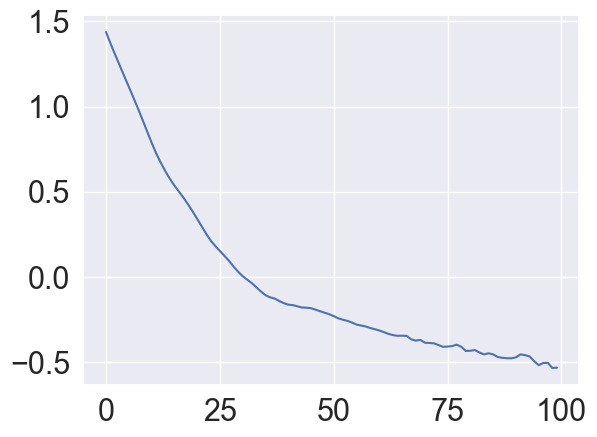

In [101]:
#if y_scale_option>0:
if y_scale_label != 'no-y-scale':
    t_train_y = torch.Tensor(scaled_y_train)
else:
    t_train_y = torch.Tensor(df_y_train.to_numpy())

#if x_scale_option>0:
if x_scale_label != 'no-x-scale':
    t_train_x = torch.Tensor(scaled_X_train)
    t_test_x = torch.Tensor(scaled_X_test)
else:
    t_train_x = torch.Tensor(df_X_train.to_numpy())
    t_test_x = torch.Tensor(df_X_test.to_numpy())

num_outputs = t_train_y.shape[-1]

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_outputs,rank = lik_rank_option)
model = MultitaskGPModel(t_train_x, t_train_y, likelihood, num_tasks= num_outputs, rank = task_rank_option)

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 100#500
ls_loss = []
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(t_train_x)
    loss = -mll(output, t_train_y)
    ls_loss.append(loss.item())
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()
plt.plot(ls_loss)

In [102]:
t_test_y = torch.Tensor(df_y_test.to_numpy())

if x_scale_option != 'no-x-scale':
    t_test_x = torch.Tensor(scaled_X_test)
else:
    t_test_x = torch.Tensor(df_X_test.to_numpy())


# Set into eval mode
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_pred = likelihood(model(t_test_x))   
        test_mean = test_pred.mean
        test_lower, test_upper = test_pred.confidence_region()
        train_pred = likelihood(model(t_train_x))
        train_mean = train_pred.mean
        train_lower, train_upper = train_pred.confidence_region()

if y_scale_option=='no-y-scale':
    arr_train_x = t_train_x.detach().numpy()
    arr_train_y = t_train_y.detach().numpy()
    arr_test_x = t_test_x.detach().numpy()
    arr_test_y = t_test_y.detach().numpy()
    arr_test_mean = test_mean.detach().numpy()
    arr_test_lower = test_lower.detach().numpy()
    arr_test_upper = test_upper.detach().numpy()

    arr_train_mean = train_mean.detach().numpy()
    arr_train_lower = train_lower.detach().numpy()
    arr_train_upper = train_upper.detach().numpy()
else:
    arr_train_x = t_train_x.detach().numpy()
    arr_train_y = y_scaler.inverse_transform(t_train_y)
    arr_test_x = t_test_x.detach().numpy()
    arr_test_y = t_test_y.detach().numpy()

    arr_train_mean = y_scaler.inverse_transform(train_mean)
    arr_train_lower = y_scaler.inverse_transform(train_lower)
    arr_train_upper = y_scaler.inverse_transform(train_upper)

    arr_test_mean = y_scaler.inverse_transform(test_mean)
    arr_test_lower = y_scaler.inverse_transform(test_lower)
    arr_test_upper = y_scaler.inverse_transform(test_upper)

/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


         Tm_1   NP_1  Tm_2   NP_2
MAE      0.36   4.22  0.68   6.05
MAE2     0.22   2.98  0.58   6.73
MSE      0.24  36.11  0.69  46.16
RMSE     0.49   6.01  0.83   6.79
MAPE     0.01   1.08  0.01   1.35
MAXE     1.10  14.01  1.63  10.63
EVS      0.13   0.55  0.45  -0.34
R2       0.12   0.54  0.11  -1.13
AVG_STD  0.45   7.37  1.84  16.72
MIN_STD  0.28   5.20  1.82  16.62
MAX_STD  1.28  18.88  1.98  17.30
         Tm_1  NP_1  Tm_2   NP_2
MAE      0.06  1.71  0.64   6.34
MAE2     0.05  1.68  0.66   6.59
MSE      0.01  3.92  0.58  55.39
RMSE     0.08  1.98  0.76   7.44
MAPE     0.00  0.53  0.01   1.55
MAXE     0.17  3.93  1.62  15.36
EVS      0.99  0.94  0.31   0.11
R2       0.99  0.94  0.31   0.10
AVG_STD  0.31  5.31  1.82  16.62
MIN_STD  0.26  5.11  1.82  16.61
MAX_STD  0.33  5.39  1.82  16.63


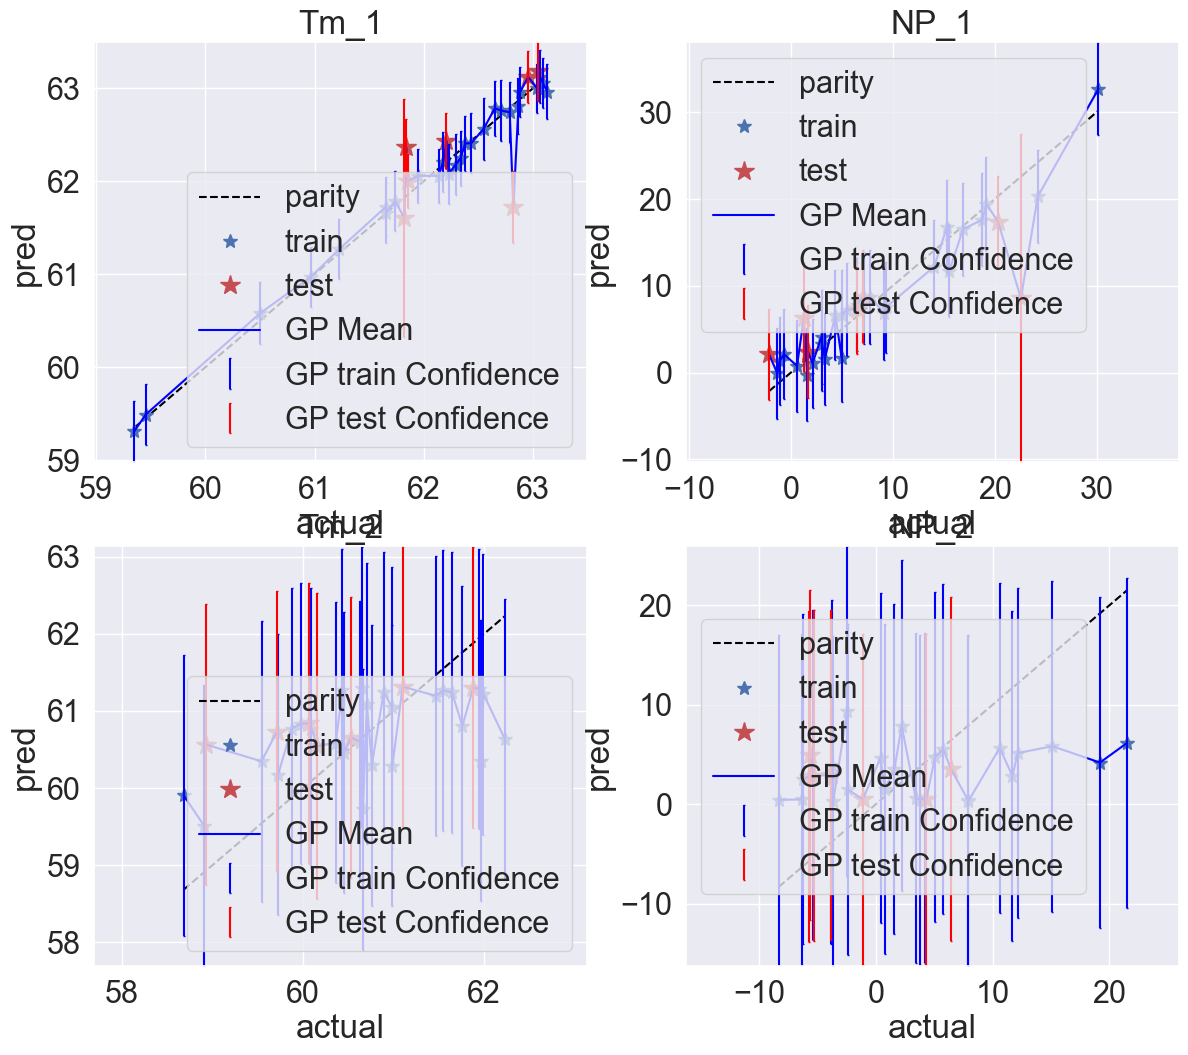

In [103]:
#from sklearn.metrics import mean_squared_error

uncertainty_figure_option = 'errorbar' #shade or errorbar
is_set_axis_limit = False
cols_target_new = df_y_new.columns

plot_axis_lb = df_y_new.min(axis = 0) - 0.4 * df_y_new.std(axis = 0)
plot_axis_ub = df_y_new.max(axis = 0) + 0.4 * df_y_new.std(axis = 0)

#num_outputs = arr_train_y.shape[-1]
#num_tasks = len(np.unique(arr_train_x[..., -1]))
num_outputs = 2
num_tasks = 2

num_total_output = num_outputs*num_tasks
arr_train_metrics = np.zeros((11,num_total_output))
arr_test_metrics = np.zeros((11,num_total_output))

# Initialize plots
#f, y_axes = plt.subplots(num_outputs,squeeze = False, figsize=(num_outputs*4, 12))
f, y_axes = plt.subplots(num_outputs, num_tasks, figsize=(num_outputs*7, 12))
y_axes = y_axes.ravel()
for task_ind in range(num_tasks):
  for j,_ in enumerate(cols_target):
    a = j + len(cols_target)*task_ind
    tmp_col_y = cols_target_new[a]

    r_train_y = arr_train_y[:,a]
    r_train_mean_y =arr_train_mean[:,a]
    r_train_lower_y =arr_train_lower[:,a]
    r_train_upper_y =arr_train_upper[:,a]
    r_train_std = r_train_mean_y - r_train_lower_y

    r_test_y = arr_test_y[:,a]
    r_test_mean_y =arr_test_mean[:,a]
    r_test_lower_y =arr_test_lower[:,a]
    r_test_upper_y =arr_test_upper[:,a]
    r_test_std = r_test_mean_y - r_test_lower_y
    
    train_comp = np.concatenate((r_train_y.reshape(-1,1),r_train_mean_y.reshape(-1,1)),axis = 1)
    df_train_comp = pd.DataFrame(train_comp,columns = ['true','pred'])
    df_train_comp['upper'] = r_train_upper_y
    df_train_comp['lower'] = r_train_lower_y
    df_train_comp['mode'] = 'train'
    
    test_comp = np.concatenate((r_test_y.reshape(-1,1),r_test_mean_y.reshape(-1,1)),axis = 1)
    df_test_comp = pd.DataFrame(test_comp,columns = ['true','pred'])
    df_test_comp['upper'] = r_test_upper_y
    df_test_comp['lower'] = r_test_lower_y
    df_test_comp['mode'] = 'test'
    
    df_comp = pd.concat([df_train_comp,df_test_comp])
    df_comp_sorted = df_comp.sort_values(by = ['true'],ascending=True)

    #plot a parity line
    y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['true'], '--',c = 'black')
    
    # Plot training data as blue stars
    y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'b*',markersize=10)

    # Plot training data as red stars
    y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'r*',markersize=15)
    # Predictive mean as blue line
    y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['pred'],c = 'blue')
    
    if uncertainty_figure_option == 'shade':
    # Shade in confidence
      y_axes[a].fill_between(x = df_comp_sorted['true'],y1 = df_comp_sorted['lower'], y2 = df_comp_sorted['upper'], color='b', alpha=.15)
    else:
      yerr = df_comp_sorted['pred'] - df_comp_sorted['lower']
      yerr = yerr.values.tolist()
      #y_axes[a].errorbar(x = df_comp_sorted['true'], y = df_comp_sorted['pred'], yerr = yerr, capsize=1, fmt='none', ecolor = 'black')
      yerr_train = df_train_comp['pred'] - df_train_comp['lower']
      yerr_train = yerr_train.values.tolist()
      yerr_test = df_test_comp['pred'] - df_test_comp['lower']
      yerr_test = yerr_test.values.tolist()
      y_axes[a].errorbar(x = df_train_comp['true'], y = df_train_comp['pred'], yerr = yerr_train, capsize=1, fmt='none', ecolor = 'blue')
      y_axes[a].errorbar(x = df_test_comp['true'], y = df_test_comp['pred'], yerr = yerr_test, capsize=1, fmt='none', ecolor = 'red')
    
    if is_set_axis_limit:
      y_axes[a].set_xlim([plot_axis_lb[j],plot_axis_ub[j]])
      y_axes[a].set_ylim([plot_axis_lb[j],plot_axis_ub[j]])
    else:
      arr_comp = df_comp[df_comp.columns.difference(['mode'])].to_numpy()
      axis_max = arr_comp.max()
      axis_min = arr_comp.min()
      y_axes[a].set_xlim([axis_min,axis_max])
      y_axes[a].set_ylim([axis_min,axis_max])

    y_axes[a].legend(['parity','train','test','GP Mean','GP train Confidence','GP test Confidence'])
    y_axes[a].set_title(tmp_col_y)
    y_axes[a].set_xlabel('actual')
    y_axes[a].set_ylabel('pred')

    y_true = r_test_y
    y_pred = r_test_mean_y
    y_train = r_train_y
    mean_train = r_train_mean_y
    

    arr_test_metrics[0,a] = np.round(metrics.mean_absolute_error(y_true, y_pred),2)
    arr_test_metrics[1,a] = np.round(metrics.median_absolute_error(y_true, y_pred),2)
    arr_test_metrics[2,a] = np.round(metrics.mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[3,a] = round(metrics.root_mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_true, y_pred),2)
    arr_test_metrics[5,a] = round(metrics.max_error(y_true, y_pred),2)
    arr_test_metrics[6,a] = round(metrics.explained_variance_score(y_true, y_pred),2)
    arr_test_metrics[7,a] = round(metrics.r2_score(y_true, y_pred),2)
    arr_test_metrics[8,a] = round(np.mean(r_test_std),2)
    arr_test_metrics[9,a] = round(np.min(r_test_std),2)
    arr_test_metrics[10,a] = round(np.max(r_test_std),2)

    arr_train_metrics[0,a] = round(metrics.mean_absolute_error(y_train, mean_train),2)
    arr_train_metrics[1,a] = round(metrics.median_absolute_error(y_train, mean_train),2)
    arr_train_metrics[2,a] = round(metrics.mean_squared_error(y_train, mean_train),2)
    arr_train_metrics[3,a] = round(metrics.root_mean_squared_error(y_train, mean_train),2)
    arr_train_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_train, mean_train),2)
    arr_train_metrics[5,a] = round(metrics.max_error(y_train, mean_train),2)
    arr_train_metrics[6,a] = round(metrics.explained_variance_score(y_train, mean_train),2)
    arr_train_metrics[7,a] = round(metrics.r2_score(y_train, mean_train),2)
    arr_train_metrics[8,a] = round(np.mean(r_train_std),2)
    arr_train_metrics[9,a] = round(np.min(r_train_std),2)
    arr_train_metrics[10,a] = round(np.max(r_train_std),2)
    arr_train_metrics[8,a] = round(np.mean(r_train_std),2)
    arr_train_metrics[9,a] = round(np.min(r_train_std),2)
    arr_train_metrics[10,a] = round(np.max(r_train_std),2)
    #arr_train_metrics[11,i] = my_gpr.kernel_.get_params()['k1__constant_value']
    #arr_train_metrics[12,i] = my_gpr.kernel_.get_params()['k2__length_scale']


if uncertainty_figure_option == 'shade' and is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-shade.jpg')
elif uncertainty_figure_option == 'shade' and ~is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-shade-zoomin.jpg')
elif uncertainty_figure_option == 'errorbar' and is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-errorbar.jpg')
elif uncertainty_figure_option == 'errorbar' and ~is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-errorbar-zoomin.jpg')

df_test_metrics = pd.DataFrame(arr_test_metrics,columns = cols_target_new, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD','MIN_STD','MAX_STD'])
print(df_test_metrics)

df_train_metrics = pd.DataFrame(arr_train_metrics,columns = cols_target_new, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD','MIN_STD','MAX_STD'])
print(df_train_metrics)


df_train_metrics.to_csv(figPath+'/df_train_metrics.csv')
df_test_metrics.to_csv(figPath+'/df_test_metrics.csv')

In [104]:
task_kern = model.covar_module.task_covar_module
covar_factor = task_kern.covar_factor #this is the W matrix (B = WW^T + diag(v))
print('W matrix',covar_factor)
print('v',task_kern.raw_var)

print('v is transformed to the following through softplus operation') #task_kern0.raw_var_constraint.transform(task_kern0.raw_var)
var = task_kern.var
print(var)

print('W W^T + diag(v) is the task kernel covariance matrix: ')
B = task_kern._eval_covar_matrix().detach().numpy()
print(np.around(B,decimals = 4))

print('Correlation matrix between tasks')
C = (B/np.sqrt(np.diag(B))).T/np.sqrt(np.diag(B))
print(np.around(C,decimals = 4))

W matrix Parameter containing:
tensor([[-0.7179,  0.2742],
        [ 0.8838,  1.0255],
        [-0.4971, -0.1549],
        [ 0.3041,  0.2223]], requires_grad=True)
v Parameter containing:
tensor([-5.8332, -4.5289, -5.9635, -6.4976], requires_grad=True)
v is transformed to the following through softplus operation
tensor([0.0029, 0.0107, 0.0026, 0.0015], grad_fn=<SoftplusBackward0>)
W W^T + diag(v) is the task kernel covariance matrix: 
[[ 0.5935 -0.3534  0.3144 -0.1574]
 [-0.3534  1.8435 -0.5982  0.4967]
 [ 0.3144 -0.5982  0.2737 -0.1856]
 [-0.1574  0.4967 -0.1856  0.1434]]
Correlation matrix between tasks
[[ 1.     -0.3378  0.7802 -0.5394]
 [-0.3378  1.     -0.8421  0.9661]
 [ 0.7802 -0.8421  1.     -0.9368]
 [-0.5394  0.9661 -0.9368  1.    ]]


In [267]:
linalg = np.linalg
tmp_mat = np.array([[ 0.1548, -0.0393,  0.0673, -0.0164],
                    [-0.0393,  2.2346, -0.3176,  0.8537],
                    [ 0.0673, -0.3176,  0.0708, -0.1222],
                    [-0.0164,  0.8537, -0.1222,  0.3277]])
L_tmp_mat = linalg.cholesky(tmp_mat)
L_tmp_mat

array([[ 0.39344631,  0.        ,  0.        ,  0.        ],
       [-0.09988656,  1.4915169 ,  0.        ,  0.        ],
       [ 0.17105256, -0.20148223,  0.03075602,  0.        ],
       [-0.04168294,  0.56957882, -0.01007989,  0.03795918]])

##M3GPR-R

In [85]:
num_outputs = t_train_y.shape[-1]

task_rank = task_rank_option
output_rank = output_rank_option
lik_rank = lik_rank_option
if lik_rank is None:
            lik_rank = output_rank

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(
                num_tasks=num_outputs, 
                rank=lik_rank if lik_rank is not None else 0,
            )

model = MultiOutputMultiTaskGP(t_train_x, t_train_y,likelihood,
                               task_rank = task_rank,output_rank = output_rank)

Iter 1/100 - Loss: 1.616
Iter 2/100 - Loss: 1.494
Iter 3/100 - Loss: 1.373
Iter 4/100 - Loss: 1.255
Iter 5/100 - Loss: 1.137
Iter 6/100 - Loss: 1.021
Iter 7/100 - Loss: 0.911
Iter 8/100 - Loss: 0.812
Iter 9/100 - Loss: 0.729
Iter 10/100 - Loss: 0.665
Iter 11/100 - Loss: 0.617
Iter 12/100 - Loss: 0.573
Iter 13/100 - Loss: 0.529
Iter 14/100 - Loss: 0.480
Iter 15/100 - Loss: 0.426
Iter 16/100 - Loss: 0.373
Iter 17/100 - Loss: 0.321
Iter 18/100 - Loss: 0.274
Iter 19/100 - Loss: 0.231
Iter 20/100 - Loss: 0.188
Iter 21/100 - Loss: 0.144
Iter 22/100 - Loss: 0.097
Iter 23/100 - Loss: 0.052
Iter 24/100 - Loss: 0.011
Iter 25/100 - Loss: -0.021
Iter 26/100 - Loss: -0.045
Iter 27/100 - Loss: -0.068
Iter 28/100 - Loss: -0.092
Iter 29/100 - Loss: -0.116
Iter 30/100 - Loss: -0.136
Iter 31/100 - Loss: -0.152
Iter 32/100 - Loss: -0.168
Iter 33/100 - Loss: -0.188
Iter 34/100 - Loss: -0.207
Iter 35/100 - Loss: -0.225
Iter 36/100 - Loss: -0.241
Iter 37/100 - Loss: -0.255
Iter 38/100 - Loss: -0.269
Iter 39

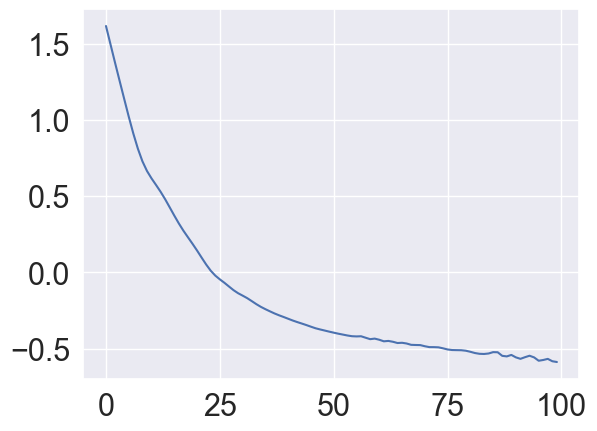

In [86]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 100
ls_loss = []
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(t_train_x)
    loss = -mll(output, t_train_y)
    ls_loss.append(loss.item())
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()
plt.plot(ls_loss)

In [87]:
t_test_y = torch.Tensor(df_y_test.to_numpy())

if x_scale_option != 'no-x-scale':
    t_test_x = torch.Tensor(scaled_X_test)
else:
    t_test_x = torch.Tensor(df_X_test.to_numpy())


# Set into eval mode
model.eval()
likelihood.eval()

MultitaskGaussianLikelihood(
  (raw_noise_constraint): GreaterThan(1.000E-04)
)

In [88]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_pred = likelihood(model(t_test_x))   
        test_mean = test_pred.mean
        test_lower, test_upper = test_pred.confidence_region()
        train_pred = likelihood(model(t_train_x))
        train_mean = train_pred.mean
        train_lower, train_upper = train_pred.confidence_region()

        #t_std_train = train_mean - train_lower
        #t_std_test = test_mean - test_lower

/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [89]:
if y_scale_option=='no-y-scale':
    arr_train_x = t_train_x.detach().numpy()
    arr_train_y = t_train_y.detach().numpy()
    arr_test_x = t_test_x.detach().numpy()
    arr_test_y = t_test_y.detach().numpy()
    arr_test_mean = test_mean.detach().numpy()
    arr_test_lower = test_lower.detach().numpy()
    arr_test_upper = test_upper.detach().numpy()

    arr_train_mean = train_mean.detach().numpy()
    arr_train_lower = train_lower.detach().numpy()
    arr_train_upper = train_upper.detach().numpy()
else:
    arr_train_x = t_train_x.detach().numpy()
    arr_train_y = y_scaler.inverse_transform(t_train_y)
    arr_test_x = t_test_x.detach().numpy()
    arr_test_y = t_test_y.detach().numpy()

    arr_train_mean = y_scaler.inverse_transform(train_mean)
    arr_train_lower = y_scaler.inverse_transform(train_lower)
    arr_train_upper = y_scaler.inverse_transform(train_upper)

    arr_test_mean = y_scaler.inverse_transform(test_mean)
    arr_test_lower = y_scaler.inverse_transform(test_lower)
    arr_test_upper = y_scaler.inverse_transform(test_upper)

/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_58785/251145997.py:60: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_58785/251145997.py:63: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red',markersize=15)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_58785/251145997.py:60: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)
/var

         Tm_1   NP_1  Tm_2   NP_2
MAE      0.53   5.22  0.59   6.85
MAE2     0.57   4.32  0.60   6.97
MSE      0.35  42.20  0.49  56.67
RMSE     0.59   6.50  0.70   7.53
MAPE     0.01   2.47  0.01   1.52
MAXE     0.82  12.08  1.13  11.44
EVS      0.83  -0.74  0.54  -0.33
R2       0.78  -2.98  0.51  -0.38
AVG_STD  1.87  16.77  1.42  13.41
MIN_STD  1.33  12.97  1.27  12.42
MAX_STD  2.66  21.93  1.69  15.01
         Tm_1   NP_1  Tm_2   NP_2
MAE      0.18   1.94  0.60   5.50
MAE2     0.12   1.71  0.55   5.33
MSE      0.06   5.95  0.57  44.84
RMSE     0.25   2.44  0.75   6.70
MAPE     0.00   0.43  0.01   1.52
MAXE     0.54   5.30  1.62  12.96
EVS      0.91   0.93  0.32   0.27
R2       0.89   0.92  0.31   0.26
AVG_STD  1.44  14.00  1.30  12.67
MIN_STD  1.33  12.93  1.27  12.39
MAX_STD  1.63  15.84  1.39  13.45


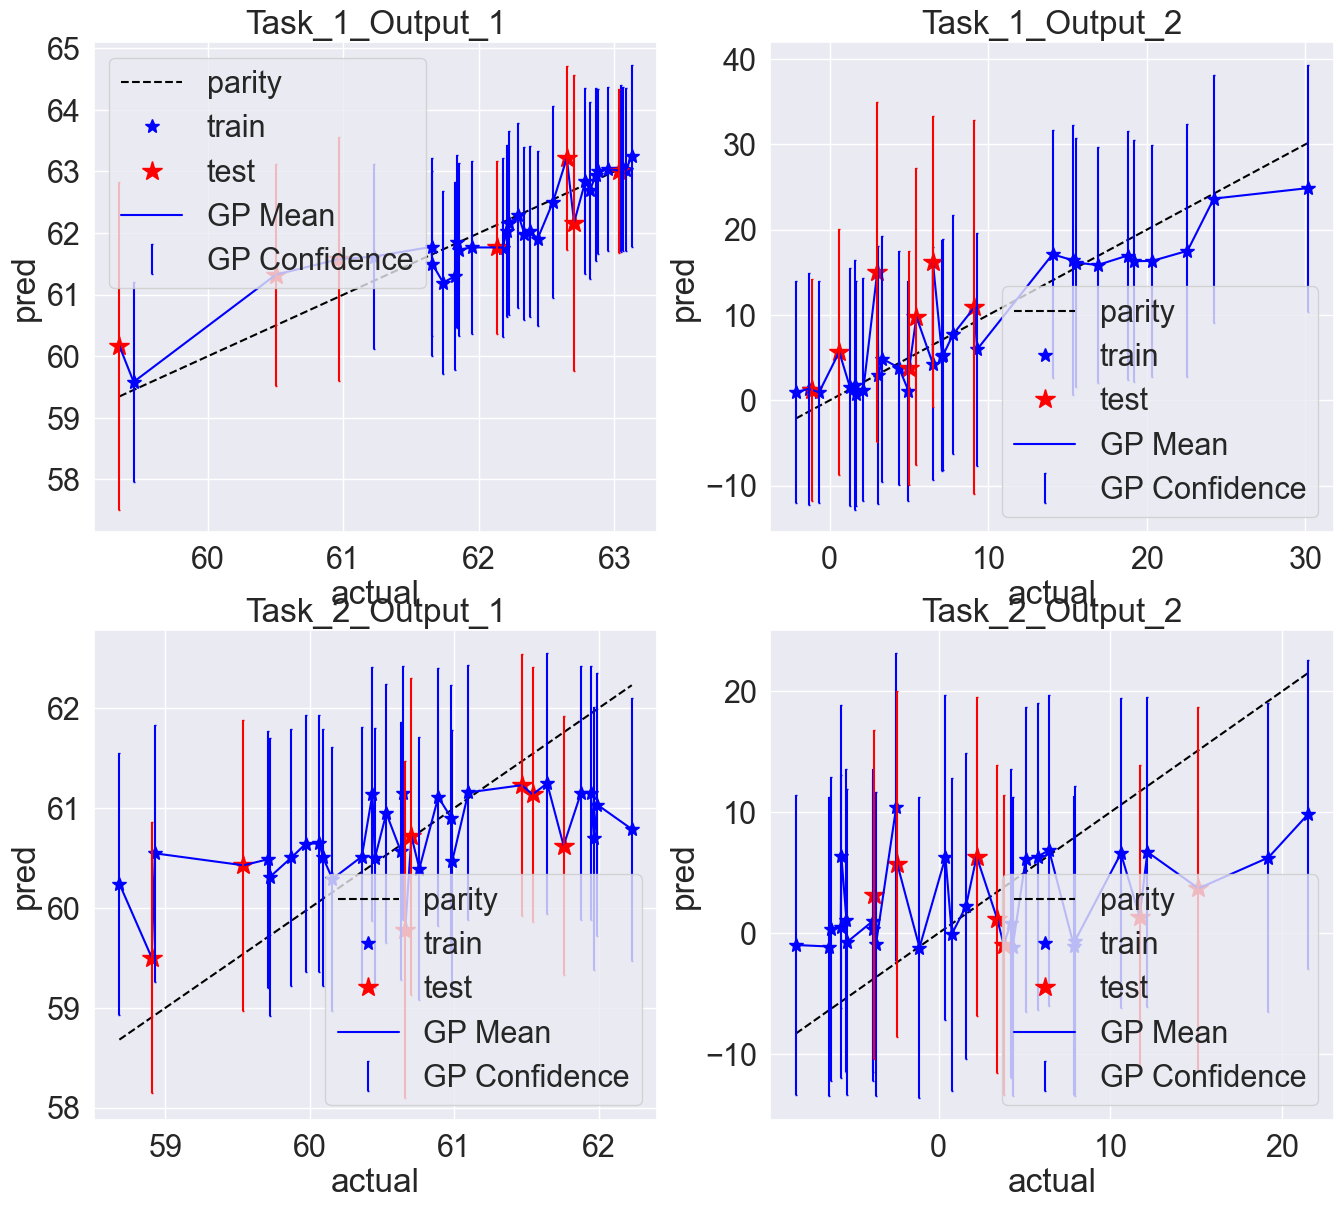

In [90]:
#from sklearn.metrics import mean_squared_error

uncertainty_figure_option = 'errorbar' #shade or errorbar
is_set_axis_limit = False
cols_target_new = ['Tm_1', 'NP_1',
       'Tm_2', 'NP_2']

plot_axis_lb = df_y.min(axis = 0) - 0.4 * df_y.std(axis = 0)
plot_axis_ub = df_y.max(axis = 0) + 0.4 * df_y.std(axis = 0)

#num_outputs = arr_train_y.shape[-1]
#num_tasks = len(np.unique(arr_train_x[..., -1]))
num_outputs = len(cols_target)
num_tasks = 2

num_total_output = num_outputs*num_tasks
arr_train_metrics = np.zeros((11,num_total_output))
arr_test_metrics = np.zeros((11,num_total_output))

# Initialize plots
#f, y_axes = plt.subplots(num_tasks, num_outputs, figsize=(16, 48))
f, y_axes = plt.subplots(num_tasks, num_outputs, figsize=(num_outputs*8, num_tasks*7))
y_axes = y_axes.ravel()
for task_ind in range(num_tasks):
  for j,_ in enumerate(cols_target):
    a = j + len(cols_target)*task_ind
    tmp_col_y = cols_target_new[a]

    r_train_y = arr_train_y[arr_train_x[:,-1]==task_ind,j]
    r_train_mean_y =arr_train_mean[arr_train_x[:,-1]==task_ind,j]
    r_train_lower_y =arr_train_lower[arr_train_x[:,-1]==task_ind,j]
    r_train_upper_y =arr_train_upper[arr_train_x[:,-1]==task_ind,j]
    r_train_std = r_train_mean_y - r_train_lower_y

    r_test_y = arr_test_y[arr_test_x[:,-1]==task_ind,j]
    r_test_mean_y =arr_test_mean[arr_test_x[:,-1]==task_ind,j]
    r_test_lower_y =arr_test_lower[arr_test_x[:,-1]==task_ind,j]
    r_test_upper_y =arr_test_upper[arr_test_x[:,-1]==task_ind,j]
    r_test_std = r_test_mean_y - r_test_lower_y
    
    train_comp = np.concatenate((r_train_y.reshape(-1,1),r_train_mean_y.reshape(-1,1)),axis = 1)
    df_train_comp = pd.DataFrame(train_comp,columns = ['true','pred'])
    df_train_comp['upper'] = r_train_upper_y
    df_train_comp['lower'] = r_train_lower_y
    df_train_comp['mode'] = 'train'
    
    test_comp = np.concatenate((r_test_y.reshape(-1,1),r_test_mean_y.reshape(-1,1)),axis = 1)
    df_test_comp = pd.DataFrame(test_comp,columns = ['true','pred'])
    df_test_comp['upper'] = r_test_upper_y
    df_test_comp['lower'] = r_test_lower_y
    df_test_comp['mode'] = 'test'
    
    df_comp = pd.concat([df_train_comp,df_test_comp])
    df_comp_sorted = df_comp.sort_values(by = ['true'],ascending=True)

    #plot a parity line
    y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['true'], '--',c = 'black')
    
    # Plot training data as blue stars
    y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)

    # Plot training data as red stars
    y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red',markersize=15)
    # Predictive mean as blue line
    y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['pred'],c = 'blue')
    
    if uncertainty_figure_option == 'shade':
    # Shade in confidence
      y_axes[a].fill_between(x = df_comp_sorted['true'],y1 = df_comp_sorted['lower'], y2 = df_comp_sorted['upper'], color='b', alpha=.15)
    else:
      yerr = df_comp_sorted['pred'] - df_comp_sorted['lower']
      yerr = yerr.values.tolist()
      #y_axes[a].errorbar(x = df_comp_sorted['true'], y = df_comp_sorted['pred'], yerr = yerr, capsize=1, fmt='none', ecolor = 'black')
      yerr_train = df_train_comp['pred'] - df_train_comp['lower']
      yerr_train = yerr_train.values.tolist()
      yerr_test = df_test_comp['pred'] - df_test_comp['lower']
      yerr_test = yerr_test.values.tolist()
      y_axes[a].errorbar(x = df_train_comp['true'], y = df_train_comp['pred'], yerr = yerr_train, capsize=1, fmt='none', ecolor = 'blue')
      y_axes[a].errorbar(x = df_test_comp['true'], y = df_test_comp['pred'], yerr = yerr_test, capsize=1, fmt='none', ecolor = 'red')
    
    if is_set_axis_limit:
      y_axes[a].set_xlim([plot_axis_lb[j],plot_axis_ub[j]])
      y_axes[a].set_ylim([plot_axis_lb[j],plot_axis_ub[j]])

    y_axes[a].legend(['parity','train','test','GP Mean','GP Confidence'])
    #y_axes[a].set_title(tmp_col_y)
    y_axes[a].set_title('Task_'+str(task_ind+1) + '_Output_'+str(j+1))
    y_axes[a].set_xlabel('actual')
    y_axes[a].set_ylabel('pred')

    y_true = r_test_y
    y_pred = r_test_mean_y
    y_train = r_train_y
    mean_train = r_train_mean_y
    

    arr_test_metrics[0,a] = np.round(metrics.mean_absolute_error(y_true, y_pred),2)
    arr_test_metrics[1,a] = np.round(metrics.median_absolute_error(y_true, y_pred),2)
    arr_test_metrics[2,a] = np.round(metrics.mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[3,a] = round(metrics.root_mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_true, y_pred),2)
    arr_test_metrics[5,a] = round(metrics.max_error(y_true, y_pred),2)
    arr_test_metrics[6,a] = round(metrics.explained_variance_score(y_true, y_pred),2)
    arr_test_metrics[7,a] = round(metrics.r2_score(y_true, y_pred),2)
    arr_test_metrics[8,a] = round(np.mean(r_test_std),2)
    arr_test_metrics[9,a] = round(np.min(r_test_std),2)
    arr_test_metrics[10,a] = round(np.max(r_test_std),2)

    arr_train_metrics[0,a] = round(metrics.mean_absolute_error(y_train, mean_train),2)
    arr_train_metrics[1,a] = round(metrics.median_absolute_error(y_train, mean_train),2)
    arr_train_metrics[2,a] = round(metrics.mean_squared_error(y_train, mean_train),2)
    arr_train_metrics[3,a] = round(metrics.root_mean_squared_error(y_train, mean_train),2)
    arr_train_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_train, mean_train),2)
    arr_train_metrics[5,a] = round(metrics.max_error(y_train, mean_train),2)
    arr_train_metrics[6,a] = round(metrics.explained_variance_score(y_train, mean_train),2)
    arr_train_metrics[7,a] = round(metrics.r2_score(y_train, mean_train),2)
    arr_train_metrics[8,a] = round(np.mean(r_train_std),2)
    arr_train_metrics[9,a] = round(np.min(r_train_std),2)
    arr_train_metrics[10,a] = round(np.max(r_train_std),2)
    #arr_train_metrics[11,i] = my_gpr.kernel_.get_params()['k1__constant_value']
    #arr_train_metrics[12,i] = my_gpr.kernel_.get_params()['k2__length_scale']


if uncertainty_figure_option == 'shade' and is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-shade.jpg')
elif uncertainty_figure_option == 'shade' and ~is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-shade-zoomin.jpg')
elif uncertainty_figure_option == 'errorbar' and is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-errorbar.jpg')
elif uncertainty_figure_option == 'errorbar' and ~is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-errorbar-zoomin.jpg')

df_test_metrics = pd.DataFrame(arr_test_metrics,columns = cols_target_new, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD','MIN_STD','MAX_STD'])
print(df_test_metrics)

df_train_metrics = pd.DataFrame(arr_train_metrics,columns = cols_target_new, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD','MIN_STD','MAX_STD'])
print(df_train_metrics)


df_train_metrics.to_csv(figPath+'/df_train_metrics.csv')
df_test_metrics.to_csv(figPath+'/df_test_metrics.csv')

Analyze the logic behind the model, dimension of intermediate output and final output

In [91]:
task_kern = model.task_kernel
covar_factor = task_kern.covar_factor #this is the W matrix (B = WW^T + diag(v))
print('W matrix',covar_factor)
print('v',task_kern.raw_var)

print('v is transformed to the following through softplus operation') #task_kern0.raw_var_constraint.transform(task_kern0.raw_var)
var = task_kern.var
print(var)

print('W W^T + diag(v) is the task kernel covariance matrix: ')
B = task_kern._eval_covar_matrix().detach().numpy()
print(np.around(B,decimals = 4))

print('Correlation matrix between tasks')
C = (B/np.sqrt(np.diag(B))).T/np.sqrt(np.diag(B))
print(np.around(C,decimals = 4))

W matrix Parameter containing:
tensor([[-1.8630,  0.5889],
        [-0.8907,  0.2804]], requires_grad=True)
v Parameter containing:
tensor([-3.9973, -4.8785], requires_grad=True)
v is transformed to the following through softplus operation
tensor([0.0182, 0.0076], grad_fn=<SoftplusBackward0>)
W W^T + diag(v) is the task kernel covariance matrix: 
[[3.8357 1.8244]
 [1.8244 0.8795]]
Correlation matrix between tasks
[[1.     0.9933]
 [0.9933 1.    ]]


In [92]:
output_kern = model.output_kernel
covar_factor = output_kern.covar_factor #this is the W matrix (B = WW^T + diag(v))
print('W matrix',covar_factor)
print('v',output_kern.raw_var)

print('v is transformed to the following through softplus operation') #task_kern0.raw_var_constraint.transform(task_kern0.raw_var)
var = output_kern.var
print(var)

print('W W^T + diag(v) is the output kernel covariance matrix: ')
B = output_kern._eval_covar_matrix().detach().numpy()
print(np.around(B,decimals = 4))

print('Correlation matrix between outputs')
C = (B/np.sqrt(np.diag(B))).T/np.sqrt(np.diag(B))
print(np.around(C,decimals = 4))

W matrix Parameter containing:
tensor([[ 0.0172, -0.0040],
        [ 0.0101, -0.0035]], requires_grad=True)
v Parameter containing:
tensor([-3.1487, -3.4353], requires_grad=True)
v is transformed to the following through softplus operation
tensor([0.0420, 0.0317], grad_fn=<SoftplusBackward0>)
W W^T + diag(v) is the output kernel covariance matrix: 
[[0.0423 0.0002]
 [0.0002 0.0318]]
Correlation matrix between outputs
[[1.     0.0051]
 [0.0051 1.    ]]


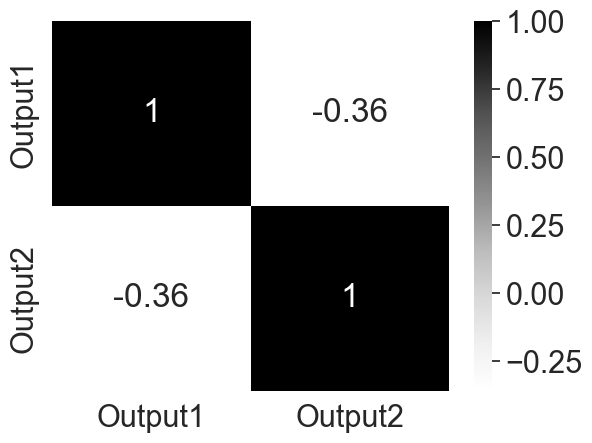

In [74]:
import seaborn as sns
sns.set(font_scale=2)
C_round = np.around(C,decimals = 2)
axis_labels = ['Output1','Output2']
heatmap = sns.heatmap(C_round, annot=True, cmap="Grays", fmt='.2g',xticklabels=axis_labels, yticklabels=axis_labels)

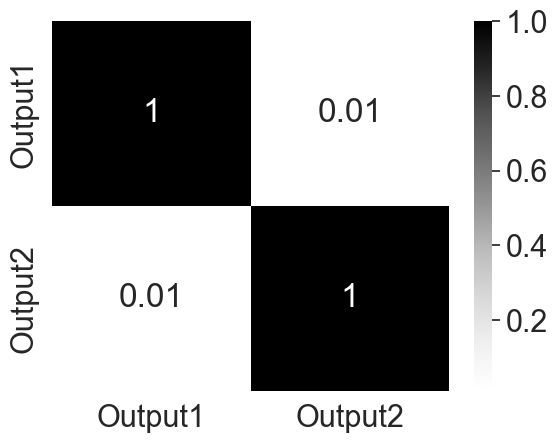

In [93]:

sns.set(font_scale=2)
C_round = np.around(C,decimals = 2)
axis_labels = ['Output1','Output2']
heatmap = sns.heatmap(C_round, annot=True, cmap="Grays", fmt='.2g',xticklabels=axis_labels, yticklabels=axis_labels)